In [540]:
import srsly

In [541]:
rel_label = ["Contributes_To"]
ents = ["base", "change_direction", "predicate", "aspect_changing"]

In [542]:
def prep_rel_data(rel_labels):
    
    file_name_answers = "checkin_answers"
    file_path_answers = "/content/" + file_name_answers + ".jsonl"
    data = srsly.read_jsonl(file_path_answers)
    final_rel_sent = []

    for entry in data:
        if "text" in entry:
            text = entry["text"]
        label_arr = []
        label_dict = {}
        if entry['answer'] == "accept":
            if entry['_session_id'] == "main_3_per_cluster-Kameron":
                for relation in entry['relations']:
                    if ("label" in relation) and ("head_span" in relation) and ("child_span" in relation):
                        if relation["label"] in rel_labels:
                            head_span_start = relation["head_span"]["start"]
                            head_span_end = relation["head_span"]["end"]
                            child_span_start = relation["child_span"]["start"]
                            child_span_end = relation["child_span"]["end"]
                            head_word = text[head_span_start:head_span_end]
                            child_word = text[child_span_start:child_span_end]
                            tmp_dict = {"head": head_word, "child": child_word, "label": relation["label"]}
                            label_arr.append(tmp_dict)
                if len(label_arr) > 0:
                    label_tup = (text, {"entities": label_arr})
                    final_rel_sent.append(label_tup)
                else:
                    pass
                    #print(text)
    return final_rel_sent
                    
final_rel_sent = prep_rel_data(rel_label)
#print(final_rel_sent)

In [543]:
def prep_ent_data(ents):
    
    file_name_answers = "checkin_answers"
    file_path_answers = "/content/" + file_name_answers + ".jsonl"
    data = srsly.read_jsonl(file_path_answers)
    label_dict = {}

    for entry in data:
        if "text" in entry:
            text = entry["text"]
        base_arr = []
        cd_arr = []
        pred_arr = []
        ac_arr = []
        if entry['answer'] == "accept":
            if entry['_session_id'] == "main_3_per_cluster-Kameron":
                for relation in entry['spans']:
                    if ("label" in relation) and ("start" in relation) and ("end" in relation):
                        child_span_start = relation["start"]
                        child_span_end = relation["end"]
                        word = text[child_span_start:child_span_end]
                        if relation["label"] in ents:
                            if relation["label"] == "base":
                                base_arr.append(word)
                            elif relation["label"] == "change_direction":
                                cd_arr.append(word)
                            elif relation["label"] == "predicate":
                                pred_arr.append(word)
                            elif relation["label"] == "aspect_changing":
                                ac_arr.append(word)

                label_dict[text] = {"base": base_arr, "change_direction": cd_arr, "predicate": pred_arr, "aspect_changing": ac_arr}
    return label_dict

final_sent_ent = prep_ent_data(ents)
#print(final_sent_ent)

In [544]:
def get_direction_counter(with_implied_base=False):
    left_to_right = 0
    right_to_left = 0
    for x in final_rel_sent:
        sent = x[0]
        for y in x[1]['entities']:
            head = y['head']
            tail = y['child']
            start_index = sent.find(head)
            end_index = sent.find(tail)
            if with_implied_base:
                if head != "IMPLIED_BASE" and tail != "IMPLIED_BASE":
                    if start_index < end_index:
                        right_to_left += 1
                    else:
                        left_to_right += 1
            else:
                if start_index < end_index:
                    right_to_left += 1
                else:
                    left_to_right += 1
    return {"left_to_right": left_to_right, "right_to_left": right_to_left}

In [545]:
print(get_direction_counter())
print(get_direction_counter(True))

{'left_to_right': 308, 'right_to_left': 514}
{'left_to_right': 246, 'right_to_left': 447}


In [546]:
"""
#!pip install benepar
#!python -m spacy download en_core_web_md
import benepar, spacy
#benepar.download('benepar_en3')
nlp = spacy.load('en')

if spacy.__version__.startswith('2'):
    nlp.add_pipe(benepar.BeneparComponent("benepar_en3"))
else:
    nlp.add_pipe("benepar", config={"model": "benepar_en3"})

def get_dep_tree():
    dep_tree = {}
    for x in final_rel_sent:
        doc = nlp(x[0])
        sent = list(doc.sents)[0]
        dep_tree[x[0]] = sent
    return dep_tree

#dep_tree = get_dep_tree()
"""

'\n#!pip install benepar\n#!python -m spacy download en_core_web_md\nimport benepar, spacy\n#benepar.download(\'benepar_en3\')\nnlp = spacy.load(\'en\')\n\nif spacy.__version__.startswith(\'2\'):\n    nlp.add_pipe(benepar.BeneparComponent("benepar_en3"))\nelse:\n    nlp.add_pipe("benepar", config={"model": "benepar_en3"})\n\ndef get_dep_tree():\n    dep_tree = {}\n    for x in final_rel_sent:\n        doc = nlp(x[0])\n        sent = list(doc.sents)[0]\n        dep_tree[x[0]] = sent\n    return dep_tree\n\n#dep_tree = get_dep_tree()\n'

In [547]:
csv = []
#features = ["sent", "base1", "base2", "all_bases", "all_cd", "all_pred", "all_ac", "left_to_right"]
features = ["sent", "base1", "base2", "all_bases", "all_cd", "all_pred", "left_to_right"]
csv.append(features)

for x in final_rel_sent:
    sent = x[0]
    for y in x[1]['entities']:
        if y["head"] != "IMPLIED_BASE" and y["child"] != "IMPLIED_BASE":
            start_index = sent.find(y["head"])
            end_index = sent.find(y["child"])
            if start_index < end_index:
                left_to_right = 0
            else:
                left_to_right = 1

            #tmp = [sent, y["head"], y["child"], ", ".join(final_sent_ent[sent]["base"]), ", ".join(final_sent_ent[sent]["change_direction"]), 
            #    ", ".join(final_sent_ent[sent]["predicate"]), ", ".join(final_sent_ent[sent]["aspect_changing"]), left_to_right]
            tmp = [sent, y["head"], y["child"], ", ".join(final_sent_ent[sent]["base"]), ", ".join(final_sent_ent[sent]["change_direction"]), 
                ", ".join(final_sent_ent[sent]["predicate"]), left_to_right]
            
            csv.append(tmp)
            tmp = []
        
print(len(csv))

694


In [548]:
import pandas as pd

df = pd.DataFrame(i for i in csv)
df.drop(0, axis=0, inplace=True)
df.columns = csv[0]
#df[10:20]
#df.to_csv('data.csv')
df['left_to_right'] = df['left_to_right'].astype(float)

In [549]:
df.head()

,sent,base1,base2,all_bases,all_cd,all_pred,left_to_right
1,"These risks are crop insurance, health care, w...",climate change.23,insurance,"insurance, health care, wildfire suppression, ...",more,due to,1.0
2,"These risks are crop insurance, health care, w...",climate change.23,health care,"insurance, health care, wildfire suppression, ...",more,due to,1.0
3,"These risks are crop insurance, health care, w...",climate change.23,wildfire suppression,"insurance, health care, wildfire suppression, ...",more,due to,1.0
4,"These risks are crop insurance, health care, w...",climate change.23,disaster relief,"insurance, health care, wildfire suppression, ...",more,due to,1.0
5,"These risks are crop insurance, health care, w...",climate change.23,flood,"insurance, health care, wildfire suppression, ...",more,due to,1.0


In [550]:
#!pip install xgboost

In [551]:
df["sent"] = df["sent"].astype('category')
df["base1"] = df["base1"].astype('category')
df["base2"] = df["base2"].astype('category')
df["all_bases"] = df["all_bases"].astype('category')
df["all_cd"] = df["all_cd"].astype('category')
df["all_pred"] = df["all_pred"].astype('category')
#df["dep_tree"] = df["dep_tree"].astype('category')
#df["all_ac"] = df["all_ac"].astype('category')

# Second, replace the strings with their code values.
df["sent"] = df["sent"].cat.codes
df["base1"] = df["base1"].cat.codes
df["base2"] = df["base2"].cat.codes
df["all_bases"] = df["all_bases"].cat.codes
df["all_cd"] = df["all_cd"].cat.codes
df["all_pred"] = df["all_pred"].cat.codes
#df["dep_tree"] = df["dep_tree"].cat.codes
#df["all_ac"] = df["all_ac"].cat.codes

# Display the table--notice how the above columns are all integers now.
df.head()

,sent,base1,base2,all_bases,all_cd,all_pred,left_to_right
1,220,64,181,173,132,69,1.0
2,220,64,156,173,132,69,1.0
3,220,64,316,173,132,69,1.0
4,220,64,98,173,132,69,1.0
5,220,64,138,173,132,69,1.0


In [552]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

feature_cols = ["sent", "base1", "base2", "all_bases", "all_cd", "all_pred"]

X = df[feature_cols]
y = df.left_to_right

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
print("Training size: {}".format(len(X_train)))
print("Testing size: {}".format(len(X_test)))

Training size: 623
Testing size: 70


In [553]:
X_train

,sent,base1,base2,all_bases,all_cd,all_pred
464,165,270,140,155,29,26
264,228,34,95,43,139,0
645,19,27,155,35,0,64
314,10,247,78,241,157,108
171,229,100,155,139,20,30
...,...,...,...,...,...,...
360,183,63,43,67,187,81
193,9,131,111,192,98,104
630,160,186,112,105,0,80
560,116,34,71,42,147,0


In [554]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Create an instance of the classifier
model = XGBClassifier(early_stopping_rounds = 10, n_estimators=300, learning_rate = 0.1)

# Train it on the training set.
model.fit(X_train, y_train)

# Use the trained model to predict the labels for the test set.
predictions = model.predict(X_test)

# Calculate the F1 score.
f1 = f1_score(y_true = y_test,
              y_pred = predictions)

print('F1: {}'.format(f1))

F1: 0.909090909090909


In [555]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, predictions)
cnf_matrix

array([[46,  3],
       [ 1, 20]])

In [556]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, predictions))

0.9428571428571428


In [557]:
predictions

array([0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 0.])

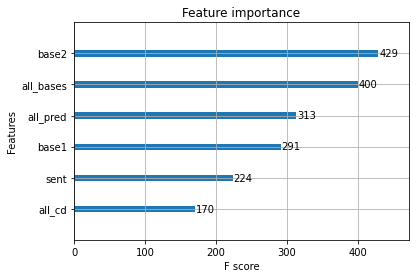

In [558]:
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(model)

pyplot.show()